# Exploratory Data Analysis for the Food Nutrients Data

## Description

Clean fetched FDC datasets contatining nutritional information about various products and explore them.

## Table of Contents

## Results summary

## Imports

In [18]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath('..'))
import src.data.utils as utils

## Data source / References

The data was obtained from [Food Data Central](https://fdc.nal.usda.gov/) (Department of Agriculture, USA). The database contains nutritional information about various products and is divided into a few sections (Foundational Foods, most recent; SR (Standard Reference) Legacy, Survey and Branded Foods). The data was fetched using "SR Legacy" type. More complete decription of the database and its contents can be found in [Foundation Foods documentation](https://fdc.nal.usda.gov/docs/Foundation_Foods_Documentation_Apr2023.pdf). 

Note: Standard Reference Legacy contains historic data on whole variety of food components including nutrients derived from analyses, calculations, and published literature but has not been updated since April 2018. 

## Outline of data being explored

There are 2 datasets stored as .csv files in /FoodDataAnalysis/data/raw/ directory.

Each of them contains data for particular kind of food (vegetables & fruits). \
Products in each food category are characterized by 10 variables:
- Energy (kcal)
- Protein (g)
- Fat (g)
- Carbohydrate (g)
- Water (g)
- Ash (g)
- Fiber (g)
- Potassium (mg)
- Sodium (mg)
- Magnesium (mg)

Nutritional quantities listed above are expressed in appropriate units per 100 grams.

Datasets ready for analysis are stored in /FoodDataAnalysis/data/processed/ directory.

## Read & clean the data 

In [19]:
data = utils.load_data('../data/raw/')
data = utils.choose_foods(data) # Datasets obtained via API contain much unnecessary information (like highly proccesed foods), that need to be filtered
data = utils.add_food_type(data) # Let's add food type for easier categorization
food_df = utils.merge_data(data) # Merge individual dataframes into one 
food_df['Description'] = food_df['Description'].str.replace(r"\(Includes foods for USDA's Food Distribution Program\)",'',regex=True)
new_columns = {'Total lipid (fat)':'Fat','Carbohydrate, by difference':'Carbohydrates','Fiber, total dietary':'Fiber','Potassium, K':'Potassium','Magnesium, Mg':'Magnesium','Sodium, Na':'Sodium'}
food_df.rename(columns=new_columns,inplace=True)
utils.save_final_datasets(data,'../data/processed/')

## Exploratory Data Analysis

In [20]:
fruits = food_df[food_df['Category'] == 'fruit']
vegs = food_df[food_df['Category'] == 'vegetable']

### Fruits

Let ud start with a quick look at the variables describing the data and calculate basic summary statistics:

In [21]:
fruits.describe()

,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,134.000000,149.000000,147.000000,150.000000
mean,95.039735,1.231921,0.654106,23.511192,73.910596,0.699139,3.555224,269.838926,17.074830,8.633333
std,83.397592,1.389204,1.924030,21.632681,22.945696,0.572220,2.682317,207.383705,14.245926,28.946471
min,19.000000,0.170000,0.040000,4.510000,7.500000,0.120000,0.100000,38.000000,3.000000,0.000000
25%,45.500000,0.540000,0.155000,10.650000,72.400000,0.335000,1.700000,135.000000,9.000000,1.000000
50%,61.000000,0.880000,0.290000,15.000000,83.500000,0.490000,2.800000,197.000000,12.000000,2.000000
75%,103.000000,1.410000,0.465000,23.750000,87.250000,0.810000,5.050000,312.000000,21.000000,6.000000
max,349.000000,14.300000,15.400000,82.800000,94.300000,3.100000,14.500000,1160.000000,92.000000,298.000000


There are some missing values in Fiber, Potassium, Magnesium and Sodium variables. Fruits in the dataset are not abundant in sodium (75th percentile is only 6 mg/100g), but are rich in potassium (median = 197 mg/100g) and contain rather low amounts of magnesium.

Each variable contains at least one outlier, which causes their distributions to be highly skewed:

In [22]:
fruits.skew(numeric_only=True).to_frame(name='Skewness')

,Skewness
Energy,1.685278
Protein,6.025738
Fat,6.565512
Carbohydrates,1.741462
Water,-1.727619
Ash,1.943830
Fiber,1.426816
Potassium,2.022147
Magnesium,2.508837
Sodium,7.975485


Due to presence of the outliers, mean is no longer a good measure of central tendency. Median, as a more robust quantity, should be used instead.

Let us have a closer look at the distributions of specific variables, using boxplots...

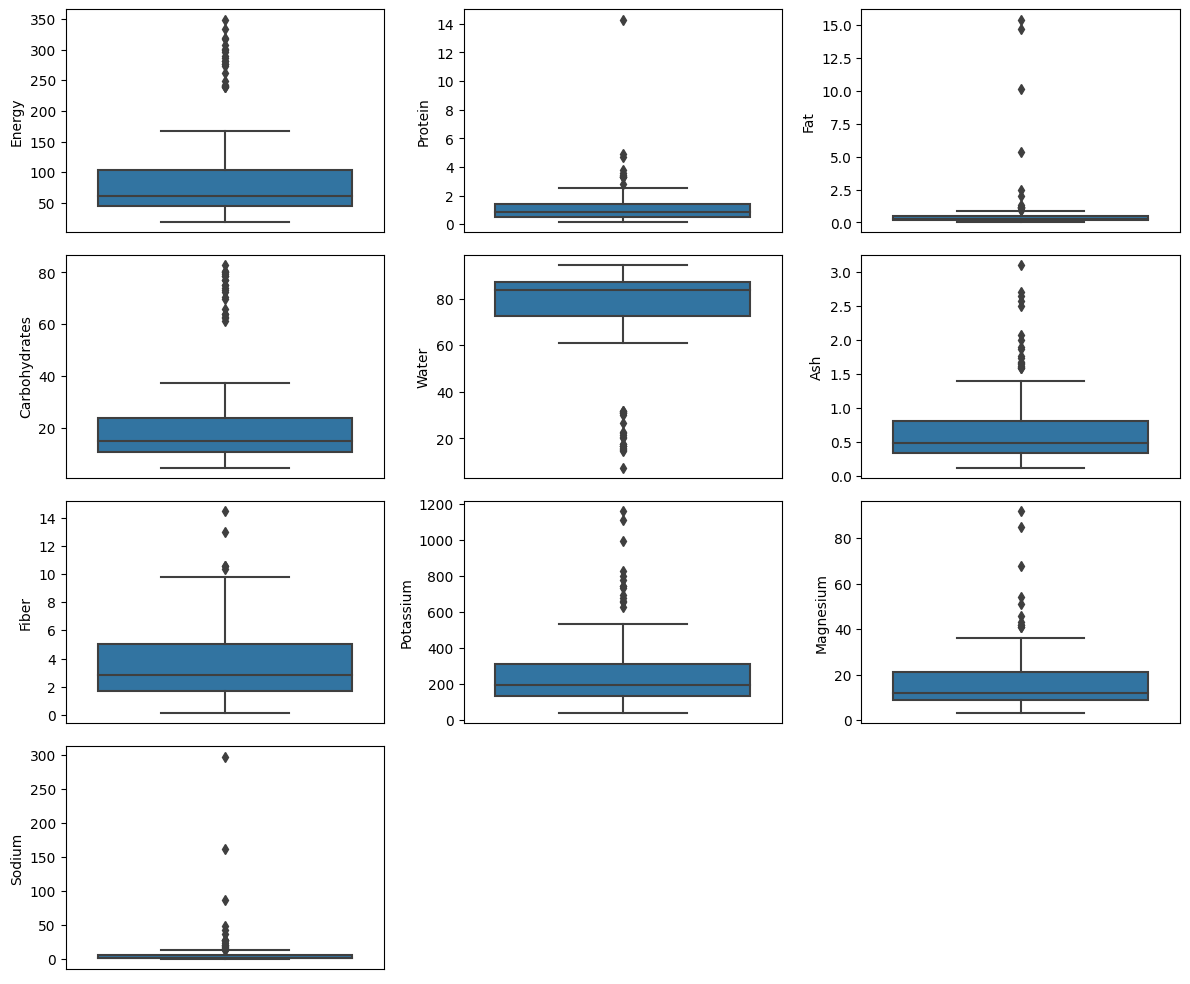

In [23]:
ax = utils.make_distribution_plot(fruits,figsize=(12,10))

... and histograms:

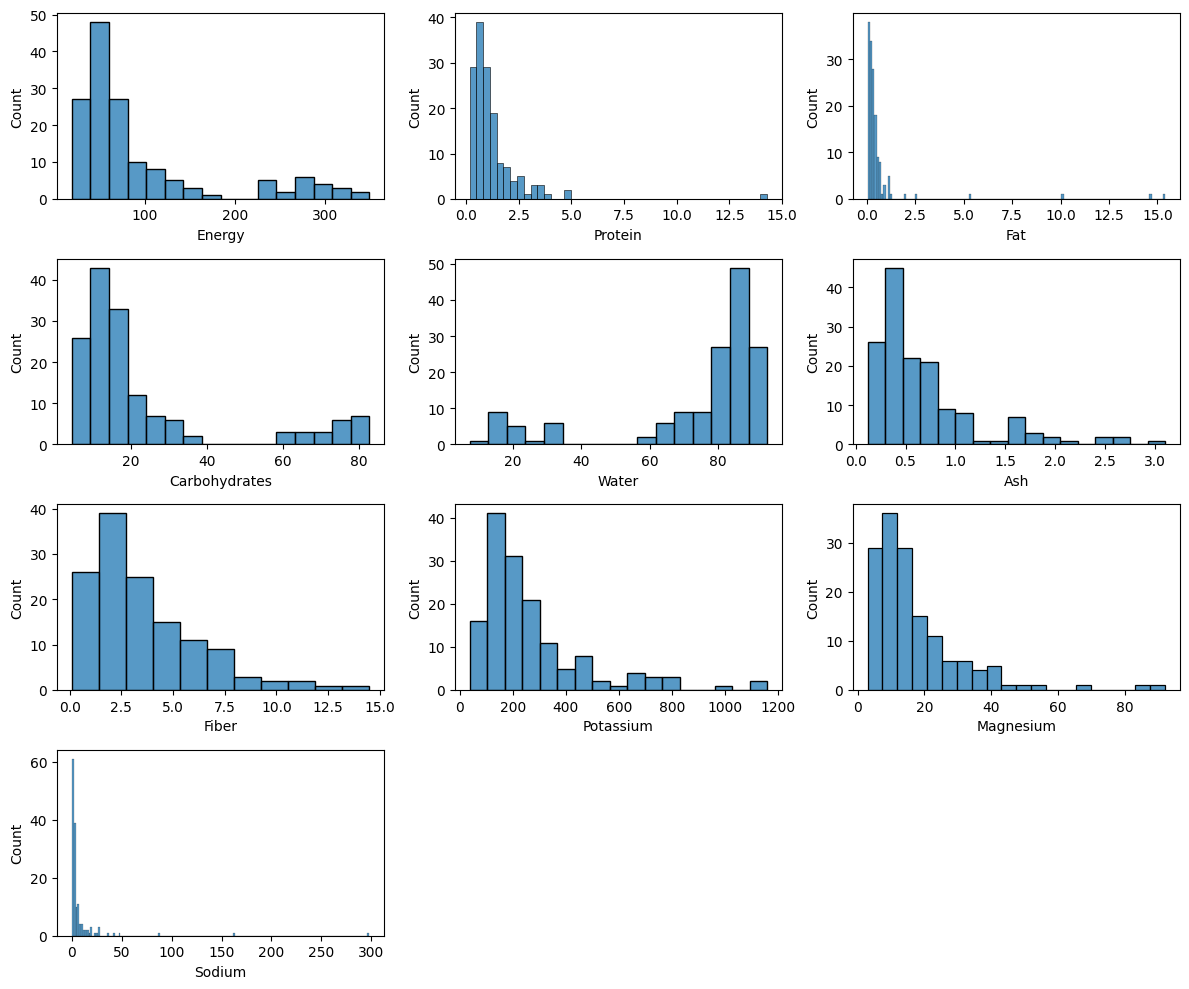

In [24]:
ax = utils.make_distribution_plot(fruits,figsize=(12,10),type='hist',nrows=4)

As we can see, there are many outliers in the dataset. It's possible that they originate from the fact that the dataset includes both fresh and dried fruits. The dried fruits typically have higher concentrations of specific nutrients (and lower water content) than the fresh ones.

Let us confirm, that this is really the case:

In [25]:
fruits_outliers = utils.find_IQR_outliers(fruits)

In [26]:
dried_outlier_summary = utils.count_outlier_dried_fruits(fruits,fruits_outliers)
dried_outlier_summary

,#Dried,%Dried
Energy,16.0,72.7
Protein,8.0,72.7
Fat,5.0,35.7
Carbohydrates,16.0,72.7
Water,16.0,72.7
Ash,9.0,50.0
Fiber,2.0,40.0
Potassium,8.0,57.1
Magnesium,5.0,45.5
Sodium,7.0,36.8


In numerous cases, particularly with quantities like carbohydrates, water, and protein, more than 50% of outliers are attributed to dried fruits. The remaining outliers could potentially be fresh fruits exhibiting exceptional levels of specific nutrients.

How would the distribution of potassium in the fruits look like if we removed those outliers?

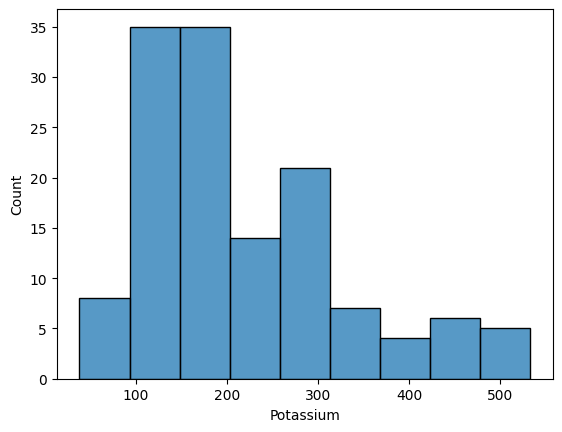

In [27]:
sns.histplot(fruits[~fruits.index.isin(fruits_outliers['Potassium'])]['Potassium']);

The distribution still exhibits skeweness, but somewhat lesser than before.

Each entry in the dataset represents a unique variety of fruit. How many types (without regard to specific variety) of fruits are there?

In [28]:
unique_fruit_types = utils.find_unique_food_types(fruits)
print(f'Number of unique types of fruits or products: {len(unique_fruit_types)}')

Number of unique types of fruits or products: 84


 An interesting question is which fruits contain exceptionally high amounts of particular nutrients. This can be useful for people, who have issues with deficienties or the other way around - who have to temporarily aviod food sources rich in that nutrient. Let's identify, for example, top 5% of the samples with greatest potassium content:

In [29]:
fruits_top_5_percent = utils.find_top_n_percent_of_samples(fruits,5)
fruits_top_5_percent['Potassium'][['Description','Potassium']]

,Description,Potassium
206,"Apricots, dried, sulfured, uncooked",1160.0
267,"Litchis, dried",1110.0
291,"Peaches, dried, sulfured, uncooked",996.0
321,"Raisins, seeded",825.0
302,"Persimmons, japanese, dried",802.0
228,"Currants, zante, dried",777.0
320,"Raisins, golden, seedless",746.0
319,"Raisins, dark, seedless",744.0


As it should be expected, all of them are dried fruits, leading with dried apricots and litchis. What about potassium content in fresh fruits?

In [30]:
fruits_fresh = fruits[~fruits['Description'].str.contains('Dried|Raisins|Dates',case=False)]
fruits_fresh_top_5_percent = utils.find_top_n_percent_of_samples(fruits_fresh,5)
fruits_fresh_top_5_percent['Potassium'][['Description','Potassium']]

,Description,Potassium
332,"Tamarinds, raw",628.0
209,"Avocados, raw, California",507.0
215,"Breadfruit, raw",490.0
310,"Plantains, yellow, raw",487.0
208,"Avocados, raw, all commercial varieties",485.0
328,"Sapote, mamey, raw",454.0


One nutrient is only a (small) part of the story. Let's see for example, how the distribution of proximates (water,fat,protein,carbohydrates and ash) in californian avocado, tamarinds, breadfruit and yellow plantains looks like:

Note: Ash represents total content of mineral and inorganic compounds in food.

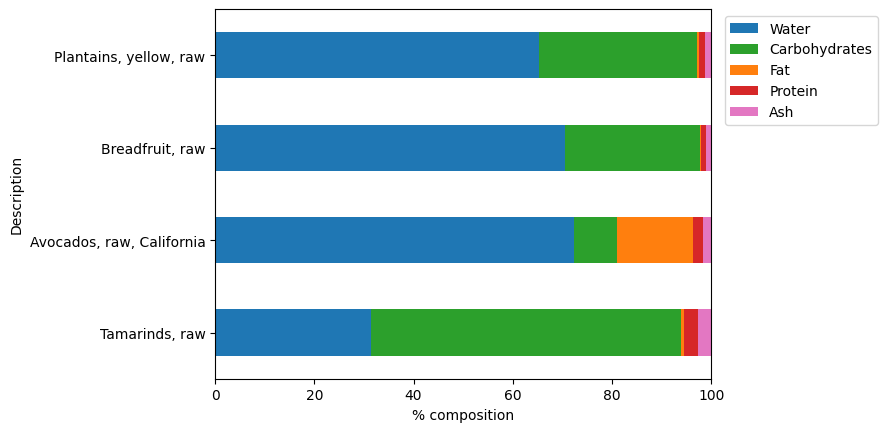

In [151]:
fruits_composition_plot = fruits_fresh_top_5_percent['Potassium'] \
                                                    [['Description','Water','Carbohydrates','Fat','Protein','Ash']] \
                                                    .loc[[332,209,215,310]]
ax = fruits_composition_plot \
    .set_index('Description') \
    .plot(kind='barh',
          stacked=True,
          color=['tab:blue','tab:green','tab:orange','tab:red','tab:pink'])
ax.set_xlim([0,100])
ax.set_xlabel('% composition')
ax.legend(bbox_to_anchor=(1.35,1));

These examples show, that composition of fruits in terms of macronutrients can vary, somethimes greatly.

Finally, we can look at bivariate distributions to see if noticable patterns emerge in the data:

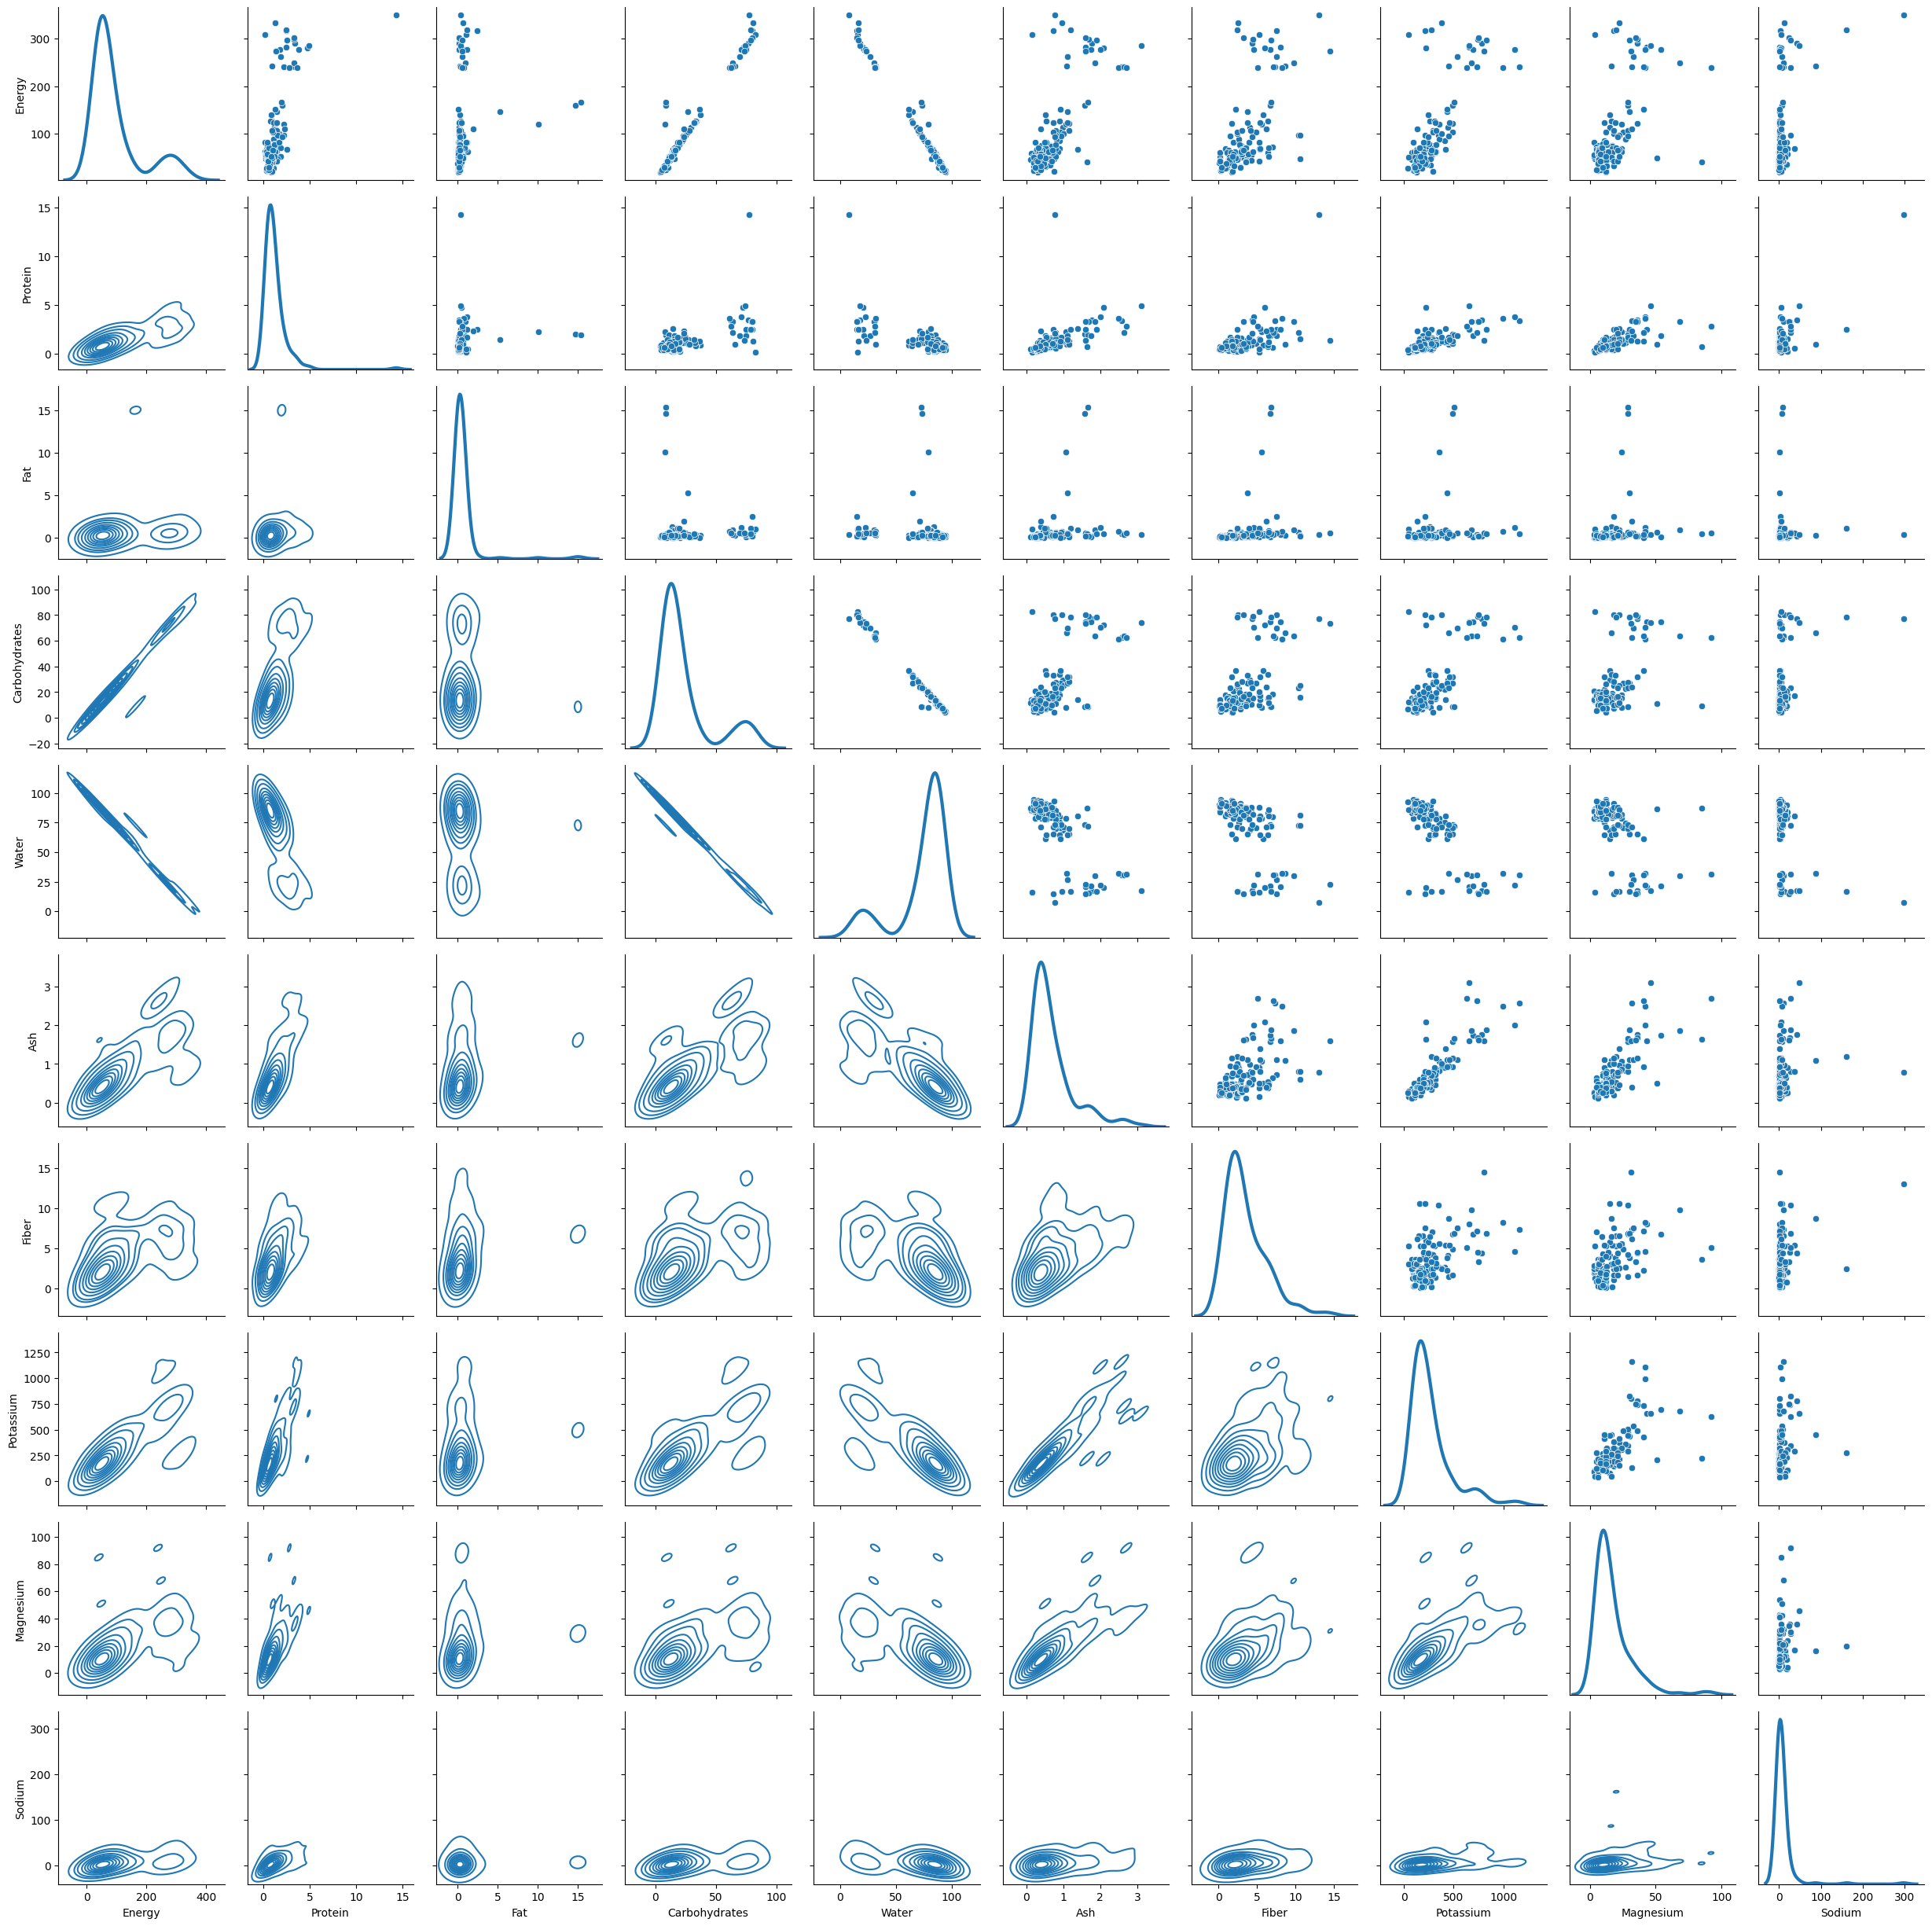

In [32]:
g = sns.PairGrid(fruits,diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);

Several variables appear to exhibit correlations to some degree. In certain instances, these correlations may emerge solely due to the definition of a particular quantity, such as the associations between ash content and various minerals. Outliers are prominently noticeable within the dataset. Some of the scatterplots (Energy-Potassium or Ash-Water) suggest the presence of what seems to resemble two distinct clusters.

### Vegetables

Let us now conduct analysis of the same kind for the dataset containing vegetables.

In [33]:
vegs.describe()

,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium
count,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,159.000000,185.000000,184.000000,185.000000
mean,41.72973,2.323622,0.382595,8.700973,87.472973,1.120541,2.420126,344.362162,30.016304,30.800000
std,31.43735,1.732791,0.404792,7.126078,8.312270,0.860423,1.565886,187.477401,25.126233,72.651626
min,10.00000,0.330000,0.010000,1.290000,57.400000,0.150000,0.300000,6.000000,2.000000,1.000000
25%,22.00000,1.200000,0.160000,3.700000,85.000000,0.640000,1.350000,233.000000,13.750000,5.000000
50%,31.00000,1.870000,0.280000,6.100000,90.500000,0.910000,2.200000,320.000000,22.000000,13.000000
75%,45.00000,2.950000,0.440000,9.560000,92.800000,1.370000,3.100000,420.000000,37.000000,27.000000
max,160.00000,11.600000,2.750000,38.100000,96.700000,7.200000,11.000000,1810.000000,156.000000,872.000000


This dataset also contains outliers in particular nutrients, just like in was in the case of fruits. Vegetables in the dataset contain low levels of protein, fat and carbohydrates (unlike fruits, for which median carbohydrate content was about 15g/100g). They are also abundant in potassium and contain somewhat more magnesium and sodium as compared to fruits.

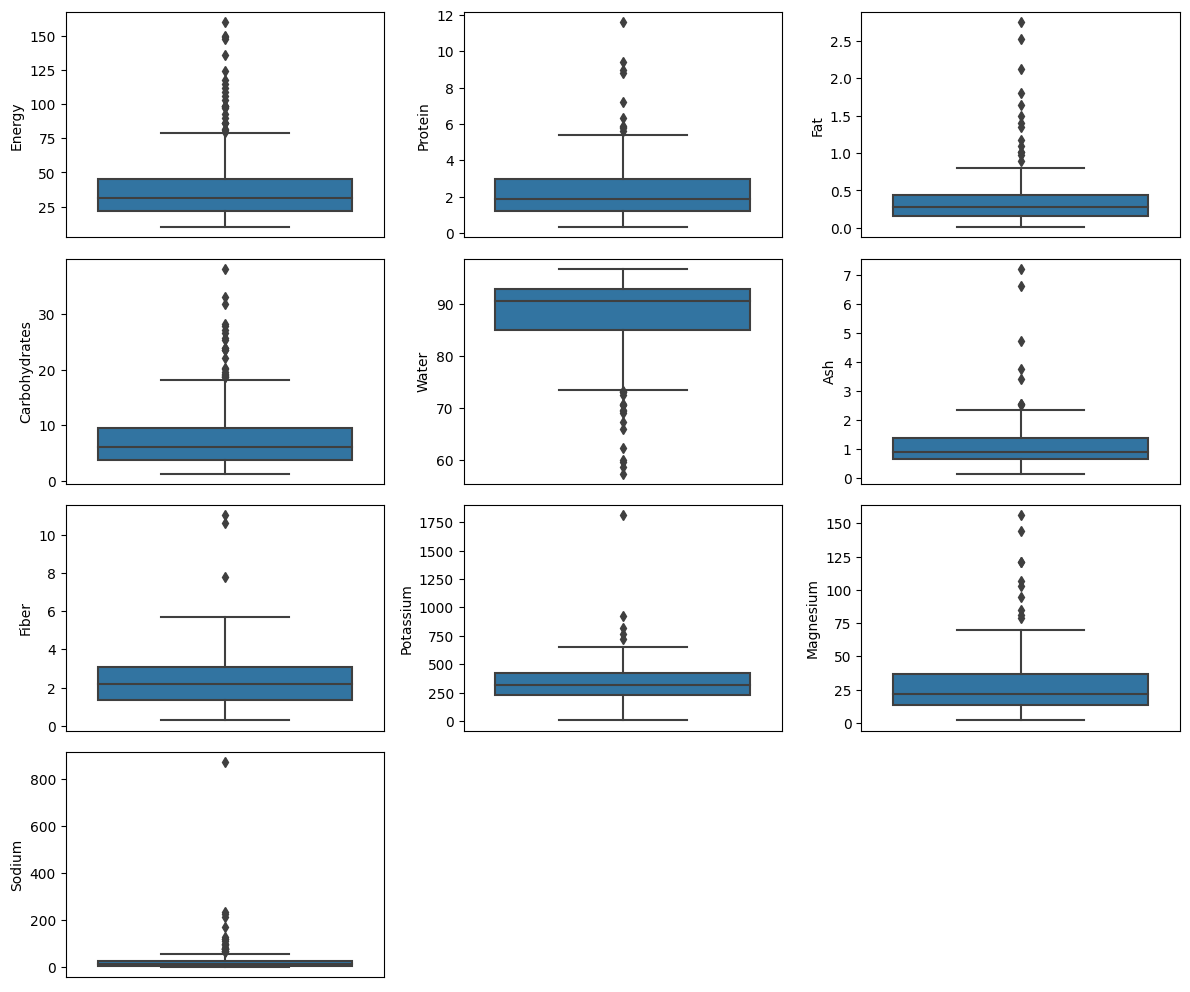

In [34]:
ax = utils.make_distribution_plot(vegs,figsize=(12,10),nrows=4)

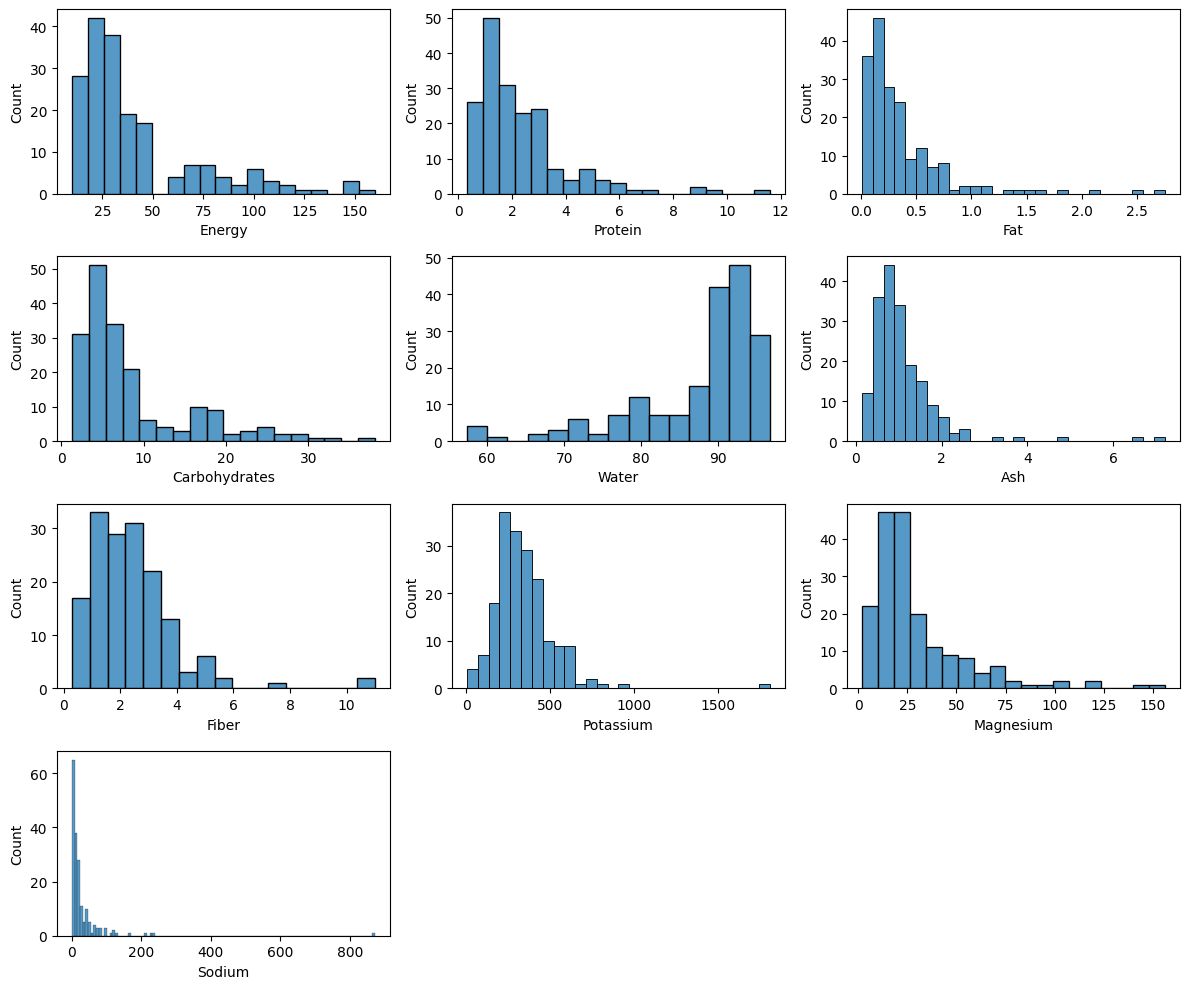

In [35]:
ax = utils.make_distribution_plot(vegs,figsize=(12,10),nrows=4,type='hist')

Both boxplots and histograms indicate that within the dataset, certain vegetables are exceptionally rich in potassium, sodium, or fat (relative to other vegetables). Which ones specifically?

In [36]:
vegetables_outliers = utils.find_IQR_outliers(vegs)
sodium_extremist = vegs.loc[vegetables_outliers['Sodium']].sort_values(by='Sodium',ascending=False).iloc[0]
potassium_extremist = vegs.loc[vegetables_outliers['Potassium']].sort_values(by='Potassium',ascending=False).iloc[0]
fat_extremist = vegs.loc[vegetables_outliers['Fat']].sort_values(by='Fat',ascending=False).iloc[0]
print(f"Name: {sodium_extremist['Description']}, Sodium content: {sodium_extremist['Sodium']}")
print(f"Name: {potassium_extremist['Description']}, Potassium content: {potassium_extremist['Potassium']}")
print(f"Name: {fat_extremist['Description']}, Fat content: {fat_extremist['Fat']}")

Name: Seaweed, wakame, raw, Sodium content: 872.0
Name: Hearts of palm, raw, Potassium content: 1810.0
Name: Fireweed, leaves, raw, Fat content: 2.75


Each vegetable variety in the dataset is unique. How many different vegetables (without distinction to their variety) are there?

In [37]:
unique_vegetabele_types = utils.find_unique_food_types(vegs)
print(f'Number of unique types of vegetables: {len(unique_vegetabele_types)}')

Number of unique types of vegetables: 118


Note: different parts of some vegetables (like roots and leafs) are counted separately.

## Analysis

After initial exploration we can proceed to actual analysis. 

### Fruits

Let's imagine, we would like to compare fresh and dried fruits in terms of their nutritional composition. We would like to know specifically:
- Are dried fruits generally higher in certain nutrients compared to fresh fruits?
- Are there particular nutrients where fresh fruits have significantly higher averages than dried fruits or vice versa?
- Are there any "fat" fruits and if so, are they fresh or dried fruits?
- Are there any fresh and/or dried fruits, which are rich in **both** potassium and sodium?
- Which variety of fresh berries provides the most energy per 100g?

Let's start with separation of original dataset into subsets, consisting of fresh and dried fruits.

In [38]:
dried_mask = fruits['Description'].str.contains('Dried|Raisins|Dates',case=False)
fruits_analysis = fruits.copy()
fruits_analysis['fruit_type'] = np.where(dried_mask,'dried','fresh')

In [39]:
def create_comparison_boxplot(df,columns_to_compare):
    df_copy = df.copy()
    columns_to_drop = df_copy.columns.drop(['fruit_type'] + columns_to_compare) 
    df_melted = pd.melt(frame=df_copy.drop(columns_to_drop,axis=1),id_vars='fruit_type',var_name='Nutrient',value_name='Value')
    fig, ax = plt.subplots(figsize=(10,8))
    sns.boxplot(df_melted,x='Nutrient',y='Value',hue='fruit_type',ax=ax)
    ax.legend(title='Type')
    return ax

### 1. Qualitative nutrient content comparison

Text(0, 0.5, 'Content / 100g (g)')

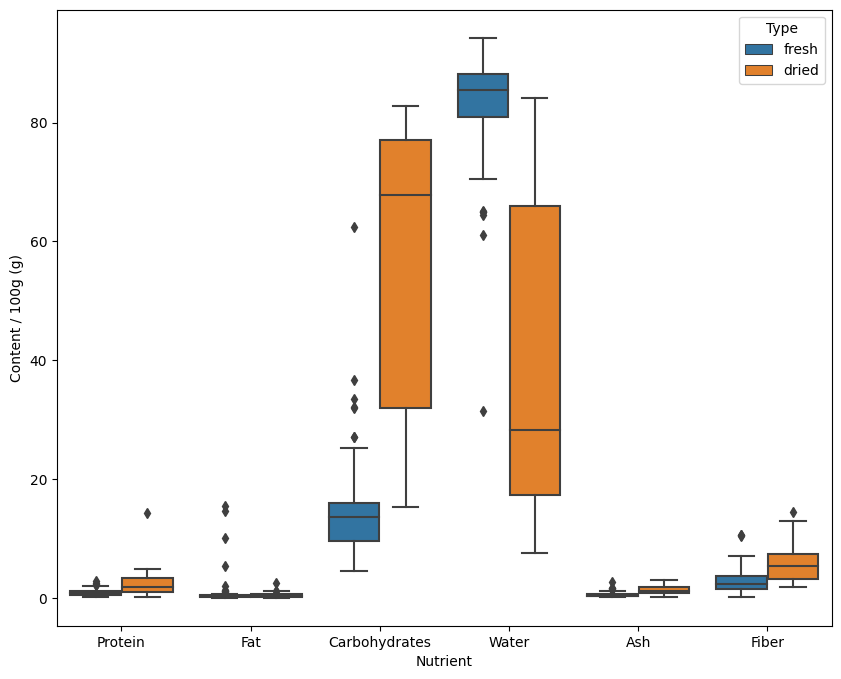

In [150]:
ax = create_comparison_boxplot(fruits_analysis,columns_to_compare=['Protein','Fat','Carbohydrates','Water','Ash','Fiber'])
ax.set_ylabel('Content / 100g (g)')

Dried fruits seem to differ from the fresh ones greatly in terms of carbohydrate and water content. The lengths of corresponding boxplots show also great variability in water and carbohydrates. Let's look at the composition of individual dried fruits, to figure out, what is the reason for this.

<Figure size 1400x1200 with 0 Axes>

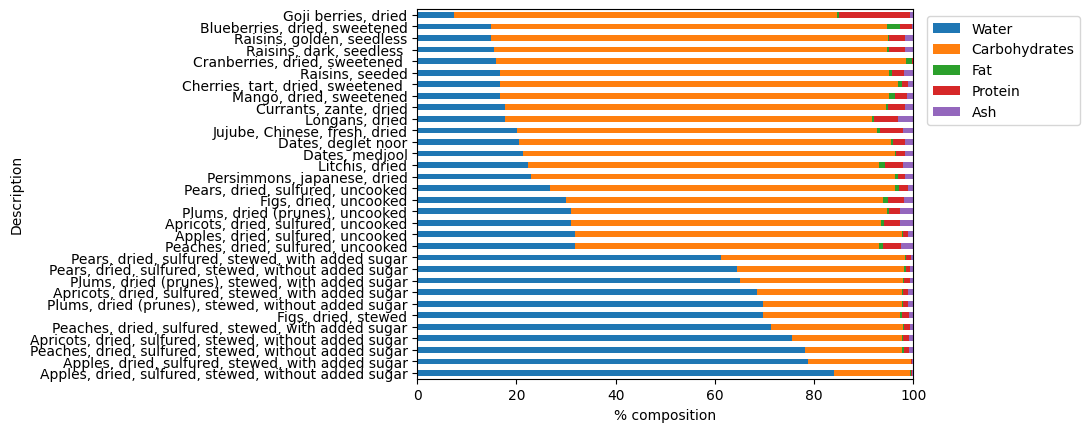

In [77]:
plt.figure(figsize=(14,12))
ax = fruits_analysis[fruits_analysis['fruit_type'] == 'dried'] \
                    [['Description','Water','Carbohydrates','Fat','Protein','Ash']] \
                    .set_index('Description') \
                    .sort_values(by='Water',ascending=False) \
                    .plot(kind='barh',stacked=True)
ax.set_xlim([0,100])
ax.set_xlabel('% composition')
ax.legend(bbox_to_anchor=(1.35,1));

Now we can see what's happening - the dataset contains also dried fruits, which were subsequently stewed, resulting in a large increase of water content and decrease in carbohydrate content. This explains the variability. If we exclude these samples, we'll obtain such an image:

Text(0, 0.5, 'Content / 100g (g)')

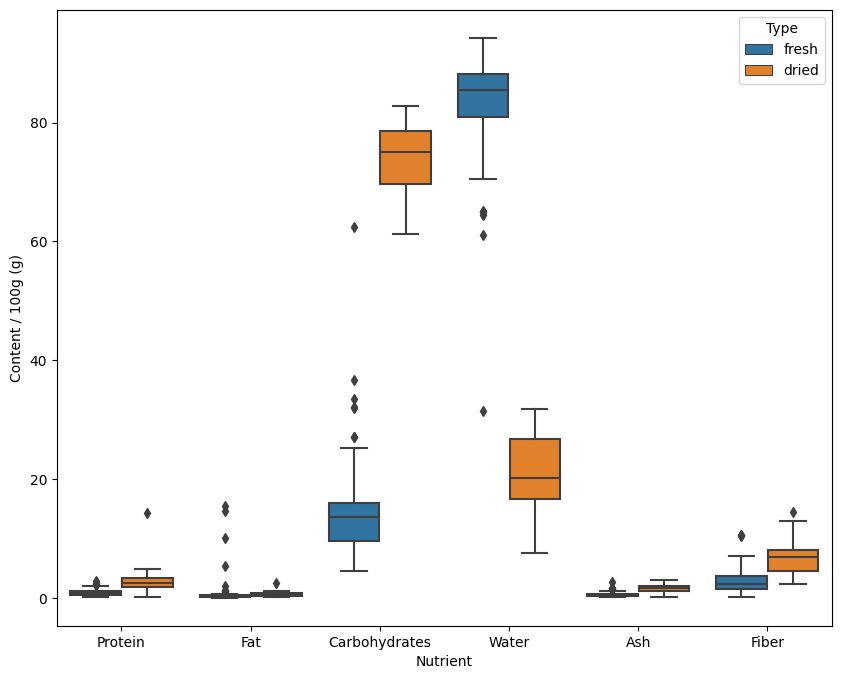

In [149]:
fruits_analysis_no_stewed_fruits = fruits_analysis[~fruits_analysis['Description'].str.contains('stewed')]
ax = create_comparison_boxplot(fruits_analysis_no_stewed_fruits,columns_to_compare=['Protein','Fat','Carbohydrates','Water','Ash','Fiber'])
ax.set_ylabel('Content / 100g (g)')

Now we can clearly see, that, dried (raw and uncooked) fruits differ greatly in terms of carbohydrate content and water content. They also seem to have higher fiber and protein content. This could be potentially attributed to the fact, that when water is removed from the fruit, the concentration of remaining nutrients automatically rises. Let's compare distributions of particular minerals as well.

Text(0, 0.5, 'Content / 100g (mg)')

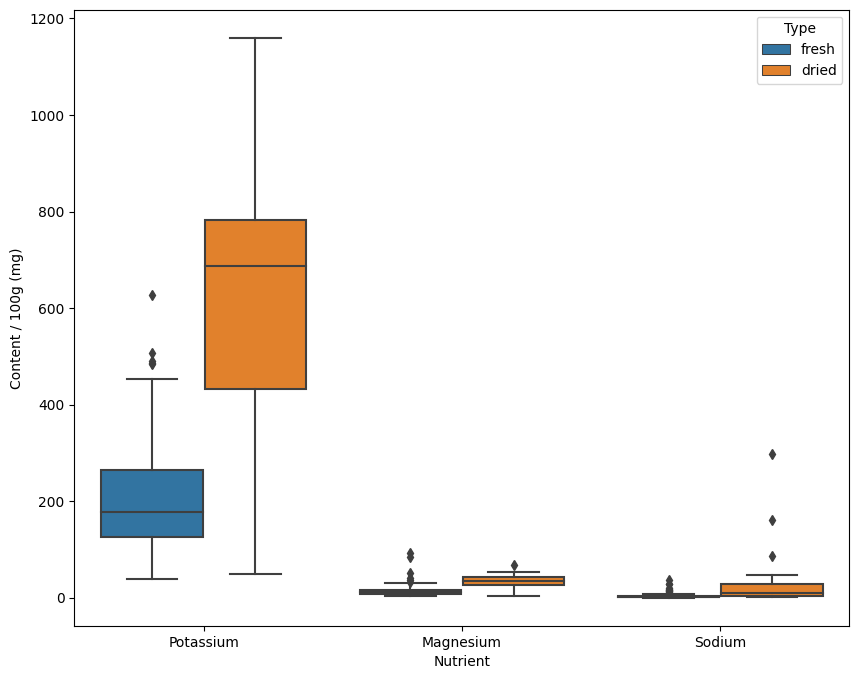

In [147]:
ax = create_comparison_boxplot(fruits_analysis_no_stewed_fruits,columns_to_compare=['Sodium','Magnesium','Potassium'])
ax.set_ylabel('Content / 100g (mg)')

Dried fruits contain much more potassium, than fresh ones. They also seem to have a little more magnesium, but its total content in both dried and fresh fruits is rather low. Due to presence of outliers and non-symmetric distributions, it's rather hard to directly compare averages between the two groups, but through visual inspection we could conclude, that dried fruits contain generally more nutrients and less water per 100g than fresh fruits, at least for samples we have at our disposal.

### 2. Identification of "fat" fruits

In [44]:
fat_fruits = utils.find_top_n_percent_of_samples(df=fruits_analysis_no_stewed_fruits,
                                                n=10,
                                                drop_cols=fruits_analysis_no_stewed_fruits.columns.drop('Fat'))['Fat']
fat_fruits[['Description','Fat']].head(10)

,Description,Fat
209,"Avocados, raw, California",15.40
208,"Avocados, raw, all commercial varieties",14.70
210,"Avocados, raw, Florida",10.10
232,"Durian, raw or frozen",5.33
213,"Blueberries, dried, sweetened",2.50
326,"Rowal, raw",2.00
217,"Carissa, (natal-plum), raw",1.30
267,"Litchis, dried",1.20
273,"Mango, dried, sweetened",1.18
315,"Pomegranates, raw",1.17


Three of 10% "fattest" fruits are varieties of avocados - California, Florida and mixed ones. 3 of 10 samples with greatest fat content are dried fruits (bluberries, litchis and mango).

Text(0.5, 0, 'Fat / 100g (g)')

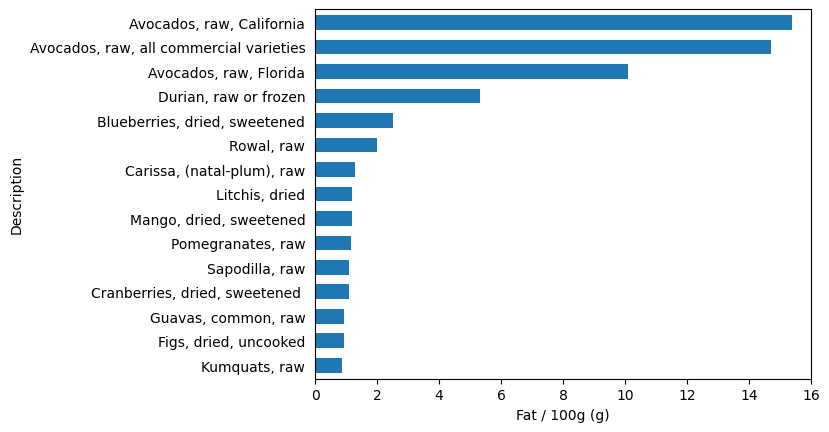

In [144]:
ax = fat_fruits[['Description','Fat']].set_index(['Description']).sort_values(by='Fat',ascending=True).plot(kind='barh',width=0.6,legend=False)
ax.tick_params(axis='y', which='both', left=False)
ax.set_xlim([0,16])
ax.set_xlabel('Fat / 100g (g)')

### 3. Fruits rich in both potassium and sodium

In [45]:
fruits_analysis_ranked = fruits_analysis_no_stewed_fruits.copy()
fruits_analysis_ranked['Potassium_rank'] = utils.ntile(fruits_analysis_ranked,column='Potassium',n=10,reverse_rank=False)
fruits_analysis_ranked['Sodium_rank'] = utils.ntile(fruits_analysis_ranked,column='Sodium',n=10,reverse_rank=False)
fruits_analysis_ranked['Score'] = fruits_analysis_ranked['Potassium_rank'] + fruits_analysis_ranked['Sodium_rank']
fruits_analysis_ranked[fruits_analysis_ranked['Score'] <= 3][['Description','Potassium','Sodium','Potassium_rank','Sodium_rank']].sort_values(by='Potassium',ascending=False)

,Description,Potassium,Sodium,Potassium_rank,Sodium_rank
206,"Apricots, dried, sulfured, uncooked",1160.0,10.0,1,2
321,"Raisins, seeded",825.0,28.0,1,1
228,"Currants, zante, dried",777.0,43.0,1,1
320,"Raisins, golden, seedless",746.0,24.0,1,1
319,"Raisins, dark, seedless",744.0,26.0,1,1
236,"Figs, dried, uncooked",680.0,10.0,1,2
269,"Longans, dried",658.0,48.0,1,1
332,"Tamarinds, raw",628.0,28.0,1,1
194,"Apples, dried, sulfured, uncooked",450.0,87.0,2,1


There are fruits rich in both potassium and sodium. Again, almost all of them (apart from tamarinds) are dried fruits.

Note: Although tamarinds contain quite low amounts of water (acually this is the most extreme outlier in one \[link\] previous boxplots), I don't consider them to be dried fruits, because water wasn't removed from them through processing after harvesting and low levels of this nutrient is rather a natural state for this fruit.

### 4. Energy content in berries

In [46]:
import importlib
importlib.reload(utils)

<module 'src.data.utils' from '/home/krzysztof/Documents/Programming/SQL/FoodDataAnalysis/src/data/utils.py'>

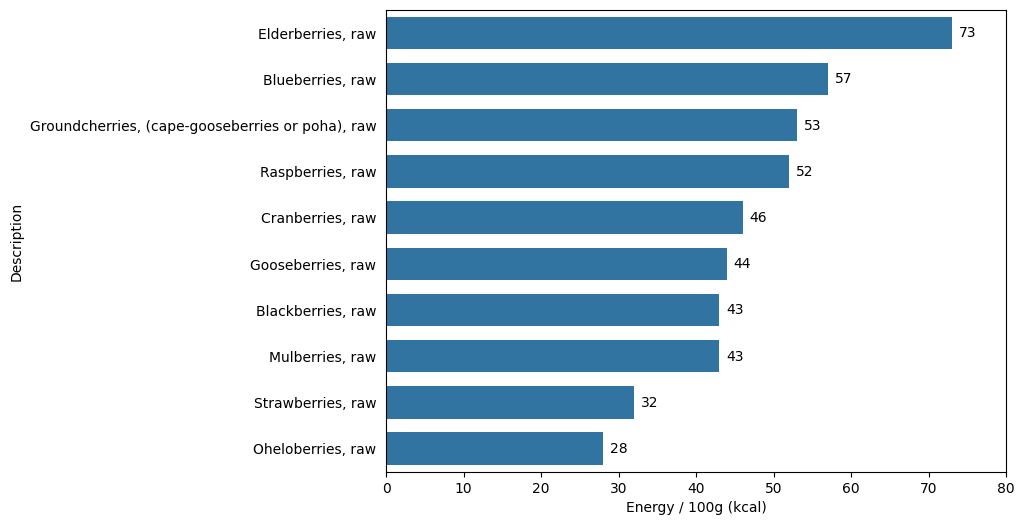

In [143]:
berries = fruits_analysis_no_stewed_fruits[fruits_analysis_no_stewed_fruits['Description'].str.contains('berries') &
                                           fruits_analysis_no_stewed_fruits['Description'].str.contains('raw')][['Description','Energy']]
plt.figure(figsize=(8,6))
ax = sns.barplot(data=berries.sort_values(by='Energy',ascending=False),y='Description',x='Energy',color='tab:blue',width=0.7)
ax.set_xlim([0,80])
ax.set_xlabel('Energy / 100g (kcal)')
ax.tick_params(axis='y',which='both',left=False)
for i, bar in enumerate(ax.patches):
    ax.annotate(xy=(bar.get_width() + 2,bar.get_y() + bar.get_height() / 2), text=str(int(bar.get_width())),ha='center',va='center')

Elderberries provide the most energy per 100g.

### Vegetables

Let' say, that we are interested in identification of 5 vegetables with highest fiber content. We would like to compare the composition of these vegetables in terms of other fundamental nutrients (proximates) and also compare their mineral content.

The questions we're seeking answers for are:
1. Which vegetables exhibit the highest fiber content?
2. How do they compare in terms of water and total carbohydrate content?
3. Are they also rich sources of magnesium, potassium or sodium?

## 1. Fiber content

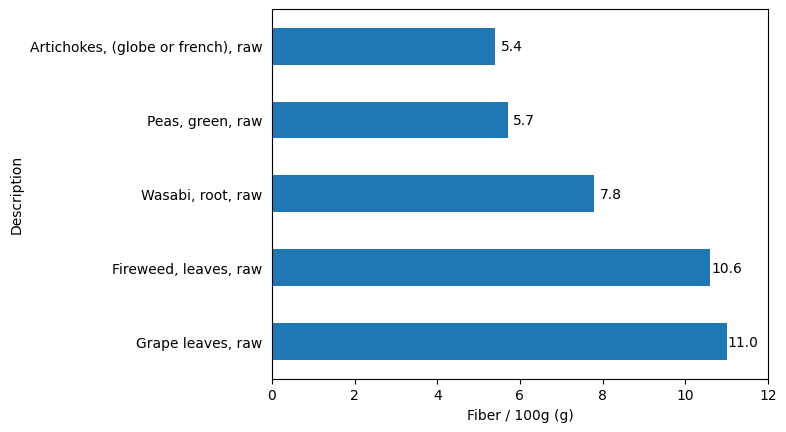

In [181]:
high_fiber_vegs_idx = vegs.sort_values(by='Fiber',ascending=False).iloc[:5].index
high_fiber_vegs = vegs.loc[high_fiber_vegs_idx][['Description','Fiber']].set_index('Description')
ax = high_fiber_vegs.plot(kind='barh',legend=False)
ax.set_xlim([0,12])
ax.set_xlabel('Fiber / 100g (g)')
ax.tick_params(axis='y',which='both',left=False)
for i, bar in enumerate(ax.patches):
    ax.annotate(xy=(bar.get_width() + 0.4,bar.get_y() + bar.get_height() / 2), text=str(bar.get_width()),ha='center',va='center')

## 2. Water and carbohydrate content comparison

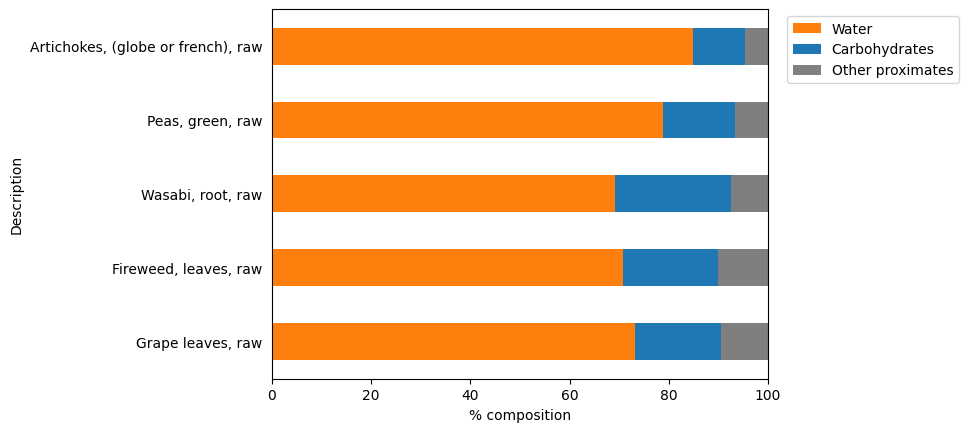

In [201]:
high_fiber_vegs_proximates = vegs.loc[high_fiber_vegs_idx][['Description','Water','Carbohydrates','Protein','Fat','Ash']].set_index('Description')
ax = high_fiber_vegs_proximates.plot(kind='barh',stacked=True,color=['tab:orange','tab:blue','tab:gray','tab:gray','tab:gray'])
ax.set_xlim([0,100])
ax.set_xlabel('% composition')
ax.tick_params(axis='y', which='both', left=False)
ax.legend(bbox_to_anchor=(1.025,1),labels=['Water','Carbohydrates','Other proximates']);

Out of 5 vegetables with highest fiber content, wasabi root contains lowest amounts of water and highest amounts of carbohydrates (including fiber). Artichokes contain the most water - over 80% of total composition.

## 3. Are these vegetables a good source of minerals as well?

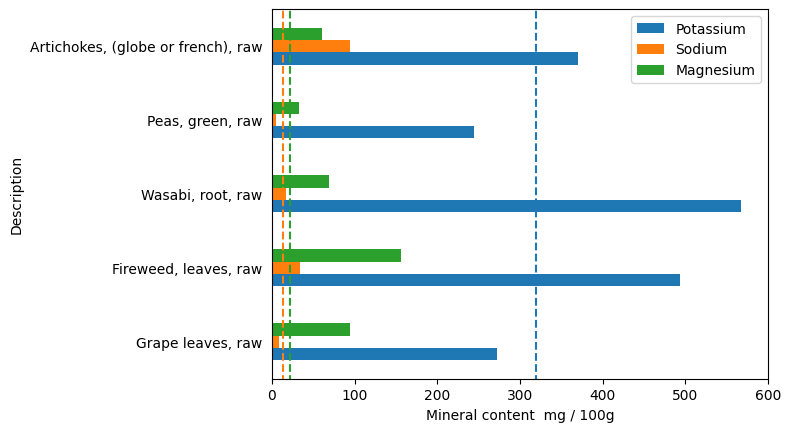

In [223]:
high_fiber_vegs_minerals = vegs.loc[high_fiber_vegs_idx][['Description','Potassium','Sodium','Magnesium']].set_index('Description')
ax = high_fiber_vegs_minerals.plot(kind='barh')
ax.tick_params(axis='y', which='both', left=False)
ax.set_xlabel('Mineral content  mg / 100g')
ax.set_xlim([0,600])
ax.vlines(x=vegs['Sodium'].median(),ymin=-1,ymax=5,linestyles='--',colors=['tab:orange'])
ax.vlines(x=vegs['Potassium'].median(),ymin=-1,ymax=5,linestyles='--',colors=['tab:blue'])
ax.vlines(x=vegs['Magnesium'].median(),ymin=-1,ymax=5,linestyles='--',colors=['tab:green'])

Dashed lines denote median contents of respective minerals. Artichokes are one of vegetables that stand out as each mineral content exceeds its respective median. Let's analyze the comparison: what percentage of the recommended daily intake is fulfilled by consuming 100 grams of artichokes?

Daily intake:
- potassium 3,400 mg (men)
- sodium: 1,500 mg
- magnesium: 420 mg (men)

Sources:
- potassium: https://ods.od.nih.gov/factsheets/Potassium-HealthProfessional/
- sodium: https://www.heart.org/en/healthy-living/healthy-eating/eat-smart/sodium/how-much-sodium-should-i-eat-per-day
- magnesium: https://ods.od.nih.gov/factsheets/Magnesium-HealthProfessional/

In [226]:
high_fiber_vegs_minerals_DV = high_fiber_vegs_minerals.copy()
high_fiber_vegs_minerals_DV['%DV_sodium'] = high_fiber_vegs_minerals_DV['Sodium'] / 1500 * 100
high_fiber_vegs_minerals_DV['%DV_potassium'] = high_fiber_vegs_minerals_DV['Potassium'] / 3400 * 100
high_fiber_vegs_minerals_DV['%DV_magnesium'] = high_fiber_vegs_minerals_DV['Magnesium'] / 420 * 100

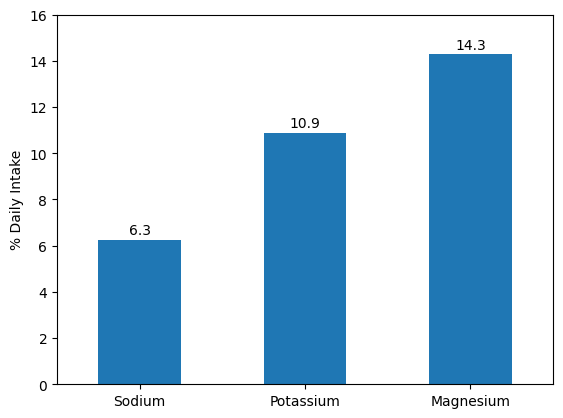

In [248]:
ax = high_fiber_vegs_minerals_DV.loc['Artichokes, (globe or french), raw',high_fiber_vegs_minerals_DV.columns.drop(['Potassium','Sodium','Magnesium'])].plot(kind='bar')
ax.set_xticklabels(['Sodium','Potassium','Magnesium'],rotation=0)
ax.set_ylabel('% Daily Intake')
ax.set_ylim([0,16])
for i, bar in enumerate(ax.patches):
    ax.annotate(xy=(bar.get_x() + bar.get_width() / 2,bar.get_height() + 0.4), text=str(np.round(bar.get_height(),1)),ha='center',va='center')

100 g of artichokes fulfills 6.3 %DV of sodium, 10.9 %DV of potassium and 14.3 %DV of magnesium.

## Conclusions